# Stock Analyzer

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import analysis
import model_arch
import model_pytorch

import warnings
warnings.simplefilter("ignore", category = FutureWarning)

In [2]:
stock_BA = analysis.retrieve_stock('BA', '2000-01-01', '2025-01-01')
log_returns_BA = analysis.log_returns(stock_BA)

stock_GME = analysis.retrieve_stock('GME', '2000-01-01', '2025-01-01')
log_returns_GME = analysis.log_returns(stock_GME)

stock_AAPL = analysis.retrieve_stock('AAPL', '2000-01-01', '2025-01-01')
log_returns_AAPL = analysis.log_returns(stock_AAPL)

## ARCH fits

### Boeing 2020

Boeing (BA) stock was heavily affected by the COVID market crash in early 2020, due to the sharp decrease in the number of passengers. By considering the log returns of this stock in the lead-up to the crash and its immediate aftermath, we see no noticeable autocorrelation in the returns themselves, but strong autocorrelation in the residuals (or, equivalently, in the squared returns). This suggests that a GARCH(1,1) model is appropriate for this data.

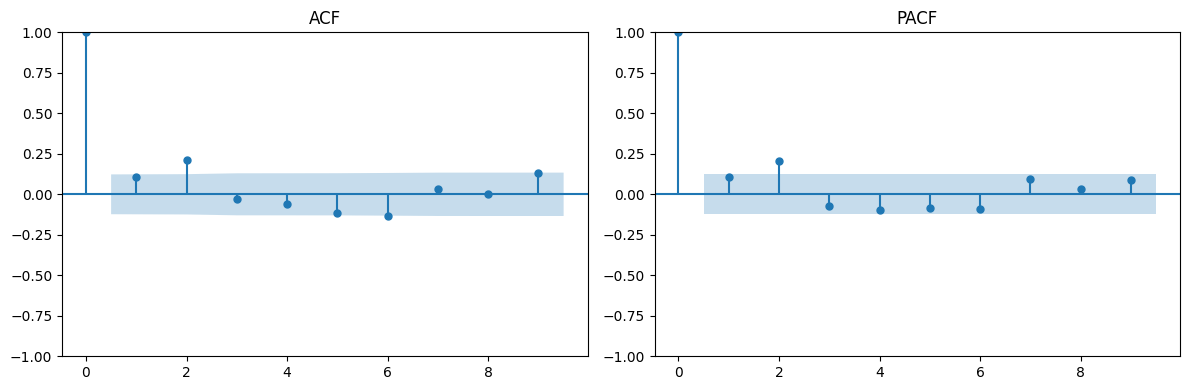

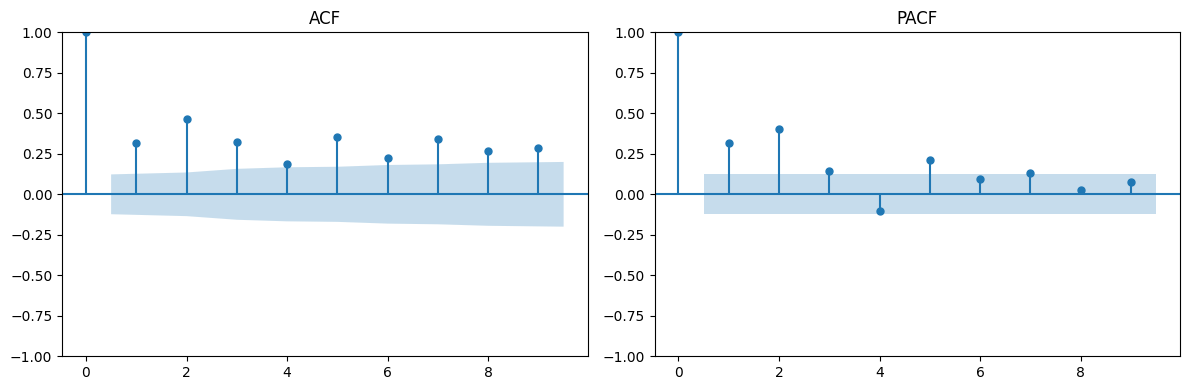

In [3]:
log_returns_BA_arch = log_returns_BA.loc['2019-10-01':'2020-10-01']

analysis.plot_acf_pacf(log_returns_BA_arch, lags = 9)
analysis.plot_acf_pacf(log_returns_BA_arch ** 2, lags = 9)

The GARCH model is incapable of predicting the crash itself, but when the initial stages of the crash are included in the fit, it can produce reliable predictions for the volatility decline following the crash.

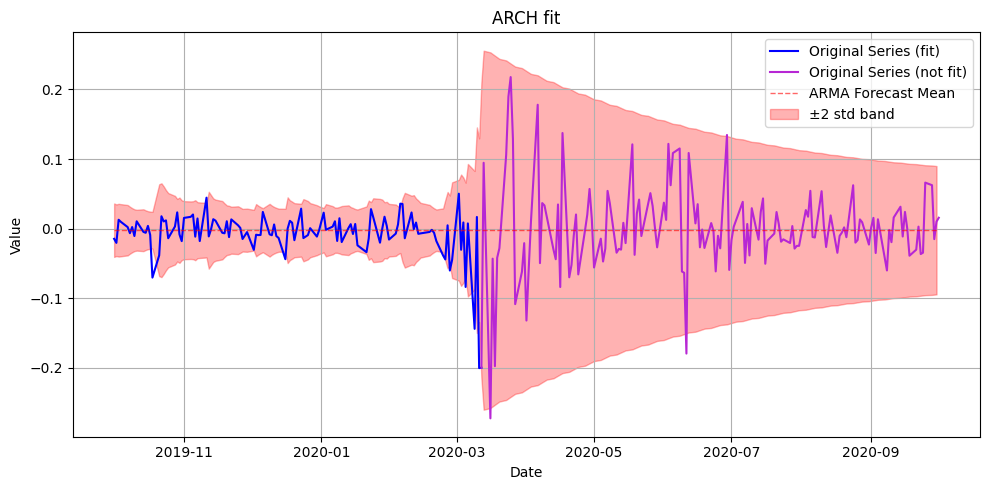

Model Diagnostics:
  Log-Likelihood: 261.21
  AIC: -514.42
  BIC: -503.51


In [16]:
arch_BA = model_arch.fit_ARCH(log_returns_BA_arch.loc[:'2020-03-12'], lags = 0, p = 1, q = 1)
model_arch.plot_series(log_returns_BA_arch, arch_BA, horizon = 144)
model_arch.print_diagnostics(arch_BA)

### Gamestop 2021

Similarly to the Boeing case considered above, the ACF/PACF plots indicate that the GARCH(1,1) fit is appropriate.

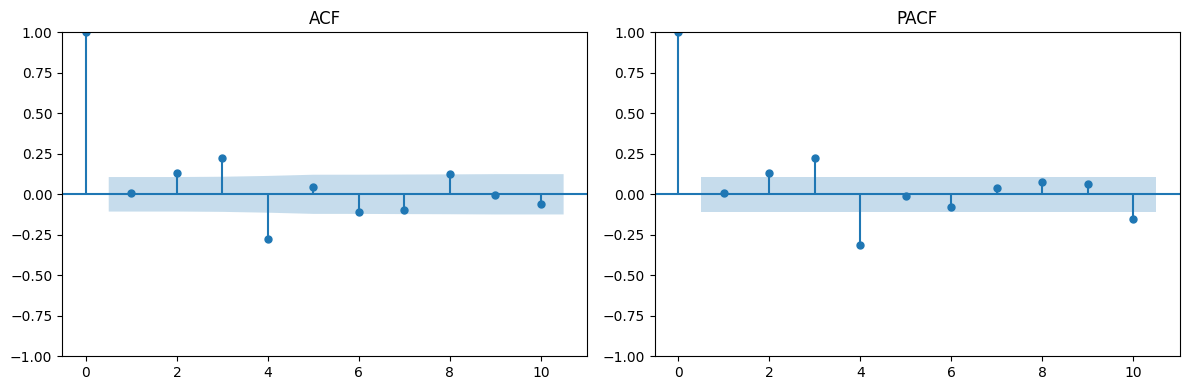

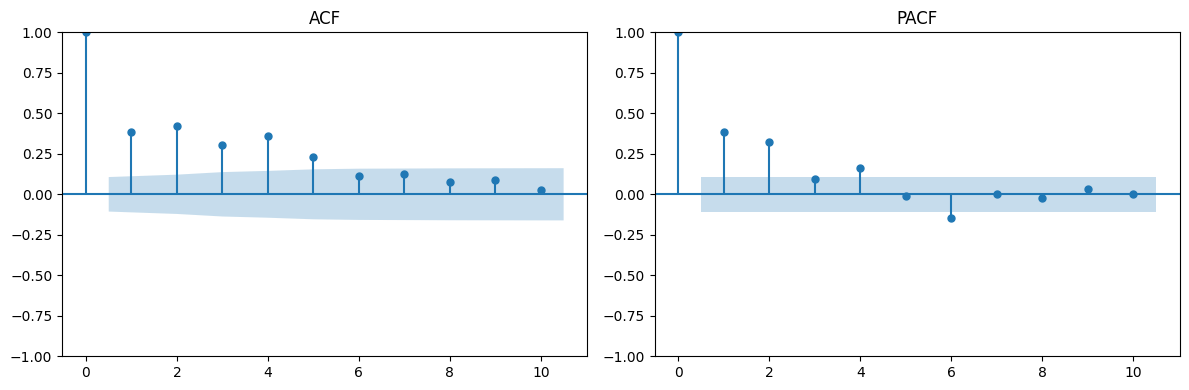

In [ ]:
log_returns_GME_arch = log_returns_GME.loc['2020-07-01':'2021-11-01']

analysis.plot_acf_pacf(log_returns_GME_arch, lags = 10)
analysis.plot_acf_pacf(log_returns_GME_arch ** 2, lags = 10)

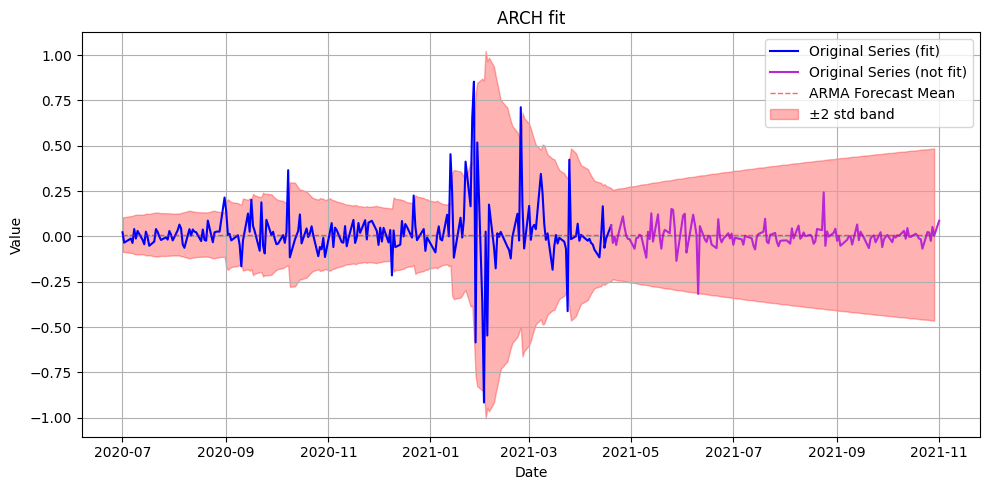

Model Diagnostics:
  Log-Likelihood: 151.40
  AIC: -294.79
  BIC: -281.58


In [6]:
arch_GME = model_arch.fit_ARCH(log_returns_GME_arch.loc[:'2021-04-19'], lags = 0, p = 1, q = 1)
model_arch.plot_series(log_returns_GME_arch, arch_GME, horizon = 139)
model_arch.print_diagnostics(arch_GME)

The GARCH model performs well in capturing the duration of the post-squeeze volatility suppression, as well as the magnitude of the subsequent volatility resurgence. Beyond that, however, the widening of the forecast cone suggests possible non-stationarity associated with the short squeeze, making long-term volatility forecasts from the GARCH model unreliable.

### Apple 2020

In both examples considered above, only the residuals of the stock returns exhibited autocorrelation. This is not always the case, as illustrated by the behavior of Apple (AAPL) stock during 2020. As shown in the ACF/PACF plots below, both the residuals and the log returns themselves display significant autocorrelation. This suggests the need for a more general modeling approach: instead of a standard GARCH(1,1) model — which captures volatility clustering via residuals alone — an augmented model with an additional AR(1) term is appropriate.

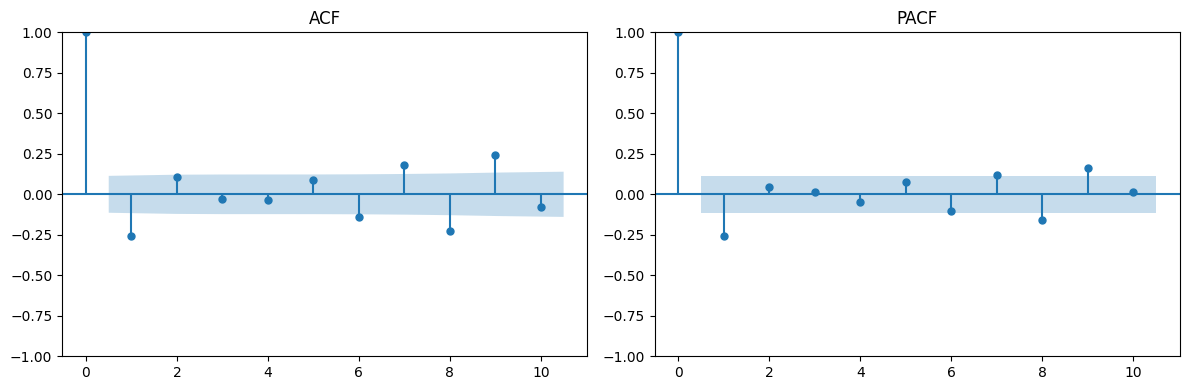

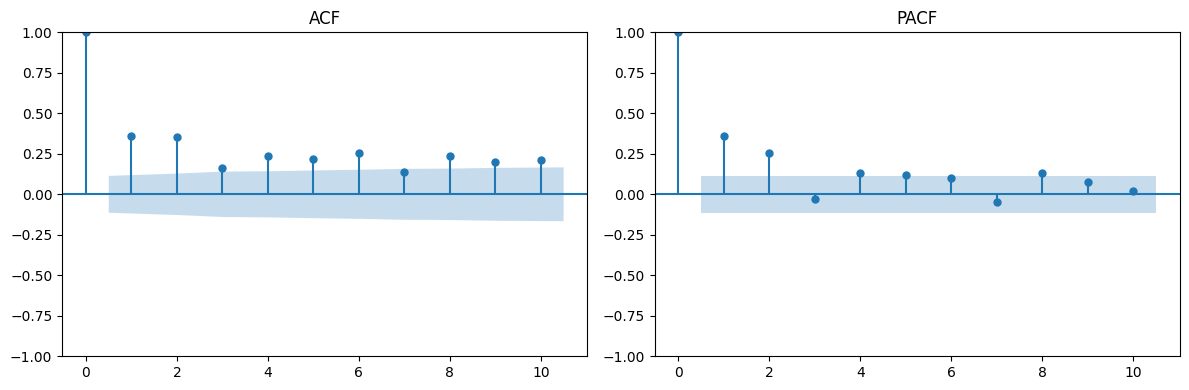

In [7]:
log_returns_AAPL_arch = log_returns_AAPL.loc['2019-10-01':'2020-12-01']

analysis.plot_acf_pacf(log_returns_AAPL_arch, lags = 10)
analysis.plot_acf_pacf(log_returns_AAPL_arch ** 2, lags = 10)

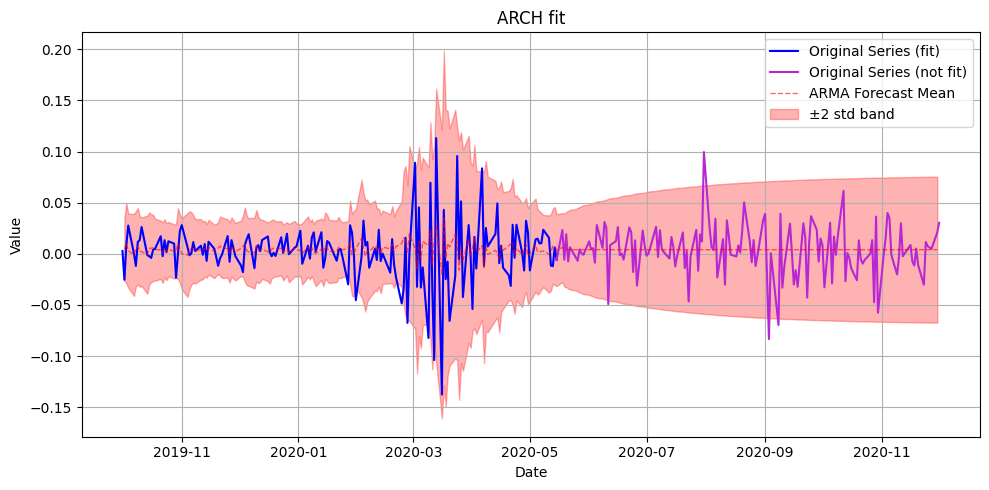

In [ ]:
arch_AAPL = model_arch.fit_ARCH(log_returns_AAPL_arch.loc[:'2020-05-15'], lags = 1, p = 1, q = 1)
model_arch.plot_series(log_returns_AAPL_arch, arch_AAPL, horizon = 141)

Excluding the AR(1) term results in a slightly narrower forecast cone, which underestimates the observed volatility.

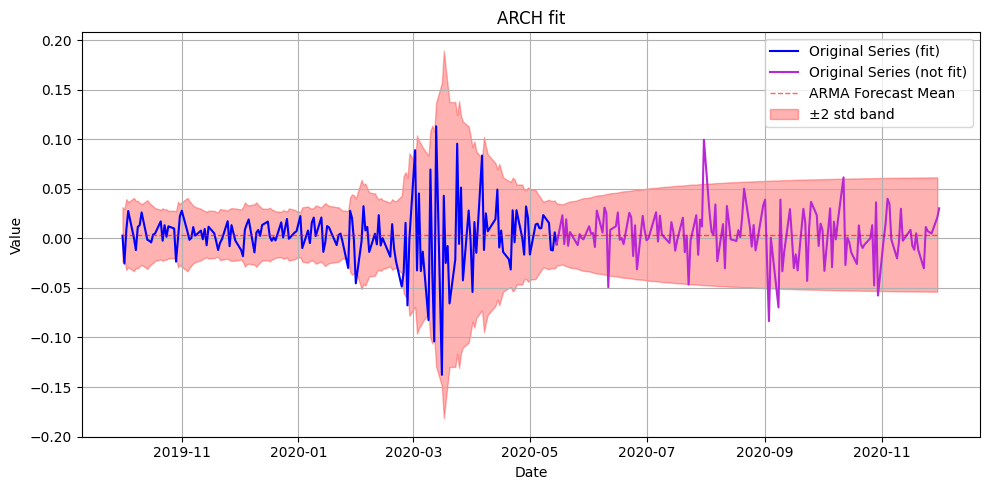

Model Diagnostics:
  Log-Likelihood: 389.05
  AIC: -768.11
  BIC: -752.83


In [17]:
arch_AAPL_no_ar = model_arch.fit_ARCH(log_returns_AAPL_arch.loc[:'2020-05-15'], lags = 0, p = 1, q = 1)
model_arch.plot_series(log_returns_AAPL_arch, arch_AAPL_no_ar, horizon = 141)
model_arch.print_diagnostics(arch_AAPL)

## PyTorch fits

ARCH models are a powerful tool for time series analysis, but are somewhat limited by the assumptions that underlie them. With the advancements in Machine Learning, we now have an alternative tool that is capable of similar fits, but without the necessity to impose assumptions by hand. We will use the PyTorch library to create a neural network (NN) capable of taking a segment of a time series with length given by the variable *window*, and then forecasting its mean and volatility beyond it for a number of steps given by the *horizon* variable. In a nutshell, such a network is supposed to learn all the features of the ARCH model by looking at the data. To train this network, we first provide it with a large dataset, on which we can perform supervised learning with the Gaussian Negative Log-Likelihood (NLL) loss function. After that, the network will be capable of taking any segment of data with length equal to *window*, and making forecasts based on that. The network contains two hidden layers, as well as dropout layers to prevent overfitting. We will use it to analyze the same datasets that were considered in previous section of the file.

### Boeing 2020

Even with the dropout layers, the network tends to overfit quite easily, which is why it is important to terminate training before the total loss computed on the validation data starts increasing. We begin our analysis by trying to replicate GARCH predictions of the 2020 Boeing stock crash. We train the NN exclusively on the pre-crash data to ensure that it doesn't see the event we're trying to model during its training.

We then train the model for fixed values of *window* and *horizon*. Even though one might naively expect that choosing *window* to be as large as possible would have a positive effect on the model's performance, this is not the case. The reason is that a model with a large *window* predominantly sees periods of stability and therefore tends to undervalue individual shocks, whose consequences we are trying to model. It is, therefore, optimal to be conservative with the value of *window*.

After training the model, we plot the training and validation losses to ensure that the model is not overfitting.

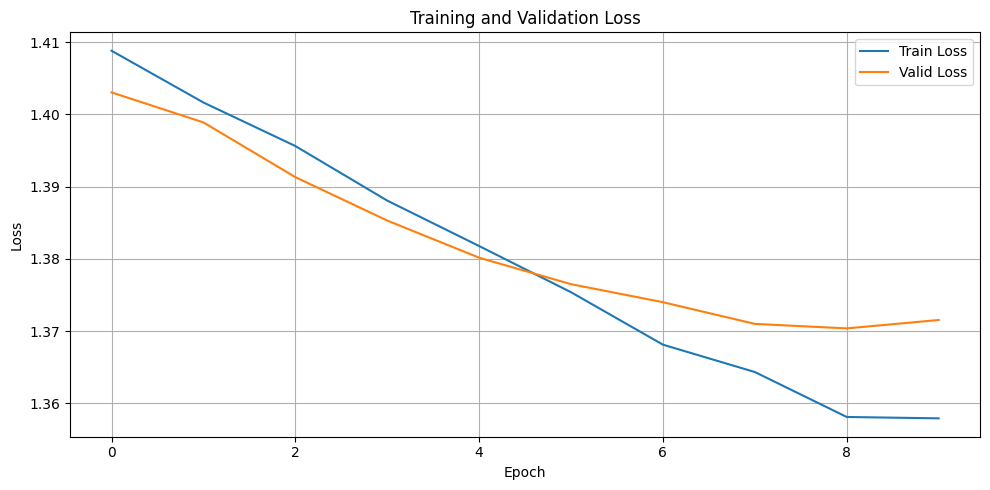

In [10]:
window, horizon = 50, 145

log_returns_BA_nn = log_returns_BA.loc[:'2020-10-01']
train, valid, scaler = model_pytorch.prepare_dataloaders(log_returns_BA_nn.loc[:'2020-03-03'], window, horizon)
model_BA, history = model_pytorch.train_model(train, valid, epochs = 10)

model_pytorch.plot_loss_history(history)

We now plot the predictions for post-2020 crash volatility of the BA stock. There is agood agreement between the NN forecast and the GARCH forecast.

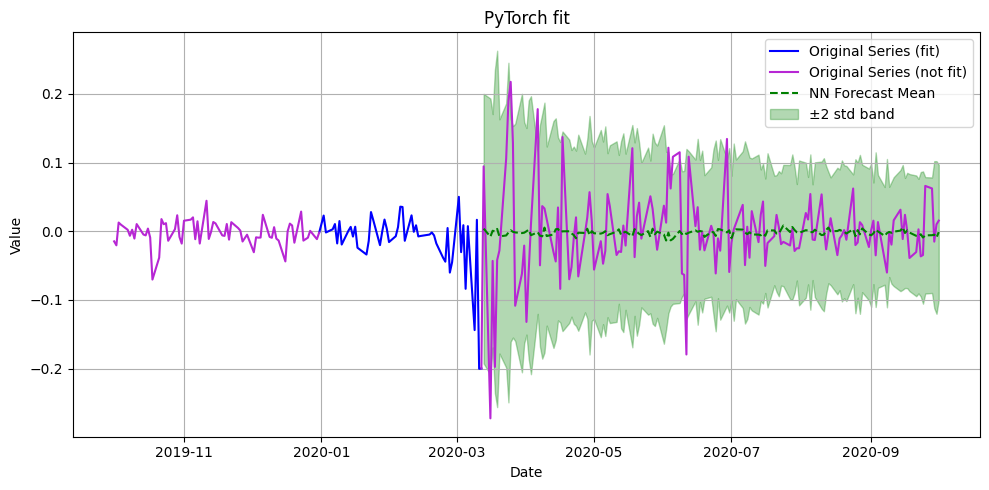

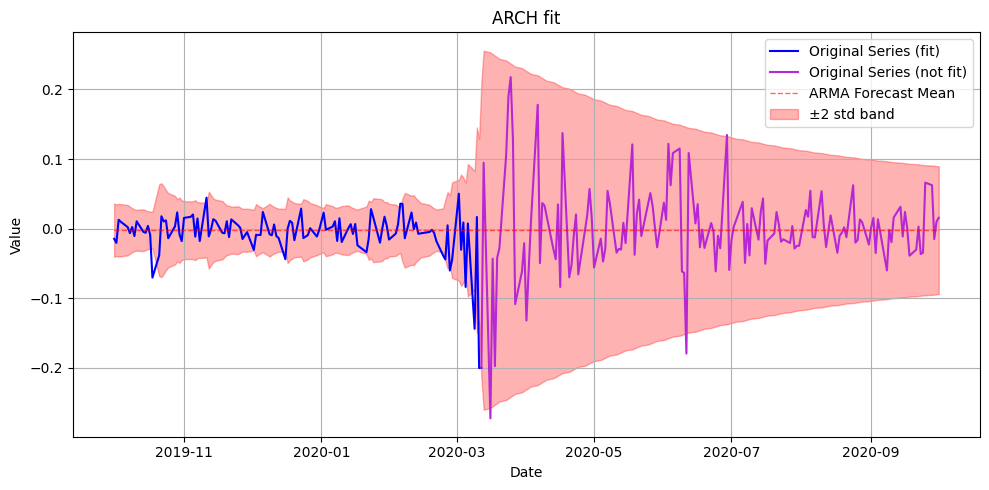

In [11]:
model_pytorch.plot_series(log_returns_BA_nn.loc['2019-10-01':], model_BA, log_returns_BA_nn.loc[:'2020-03-12'].iloc[- window:], scaler = scaler)
model_arch.plot_series(log_returns_BA_nn.loc['2019-10-01':], arch_BA, horizon = horizon)

### Gamestop 2021

The model for the aftermath of the Gamestop short squeeze is somewhat harder to train because of the non-stationary nature of this event. When trained on a large dataset, the model predominantly sees periods of stability and, therefore, does not have sufficient opportunity to learn non-stationary behavior. To address this, we include the crash period itself in the training data and restrict how far back the training set extends in order to increase the relative weight of samples near the crash. As before, the post-crash data that we aim to model is excluded from training and remains unseen by the model.

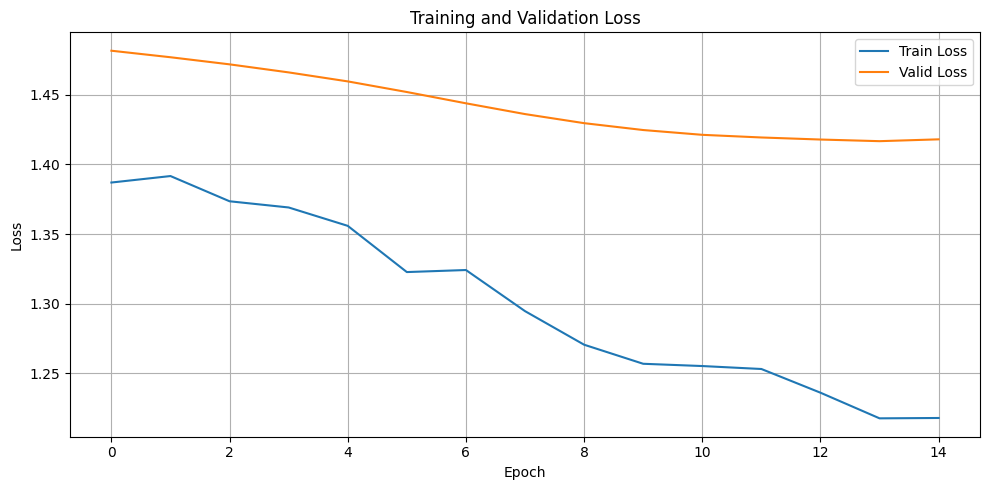

In [12]:
window, horizon = 180, 95

log_returns_GME_nn = log_returns_GME['2018-01-01':'2021-08-30']
train, valid, scaler = model_pytorch.prepare_dataloaders(log_returns_GME_nn.loc[:'2021-04-19'], window, horizon)
model_GME, history = model_pytorch.train_model(train, valid, epochs = 15)

model_pytorch.plot_loss_history(history)

Remarkably, the model clearly anticipates volatility clustering post-crash, even more so than the ARCH model. However, the quantitative aspects of this prediction (i.e., the cluster duration) seem to be somewhat dependent on the model parameters, mainly *horizon*. It appears that a more sophisticated model would be required to achieve robust quantitative predictions.

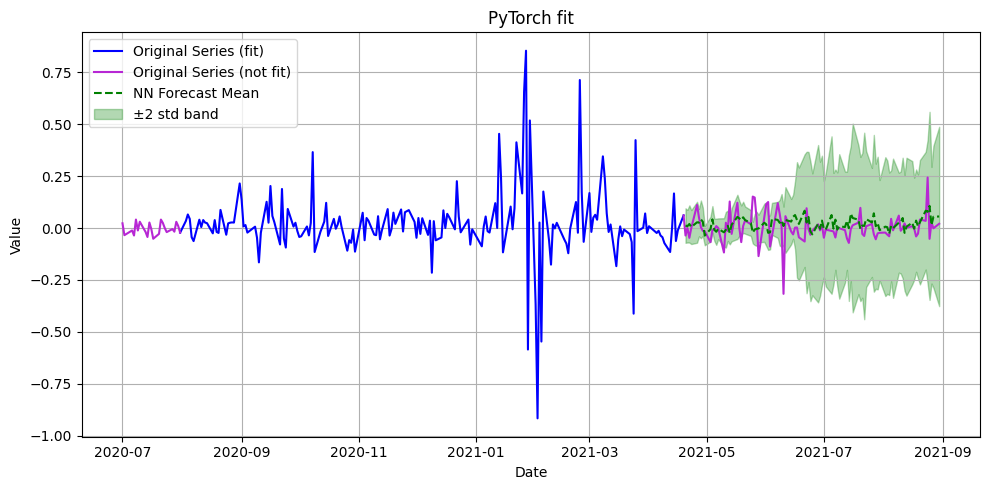

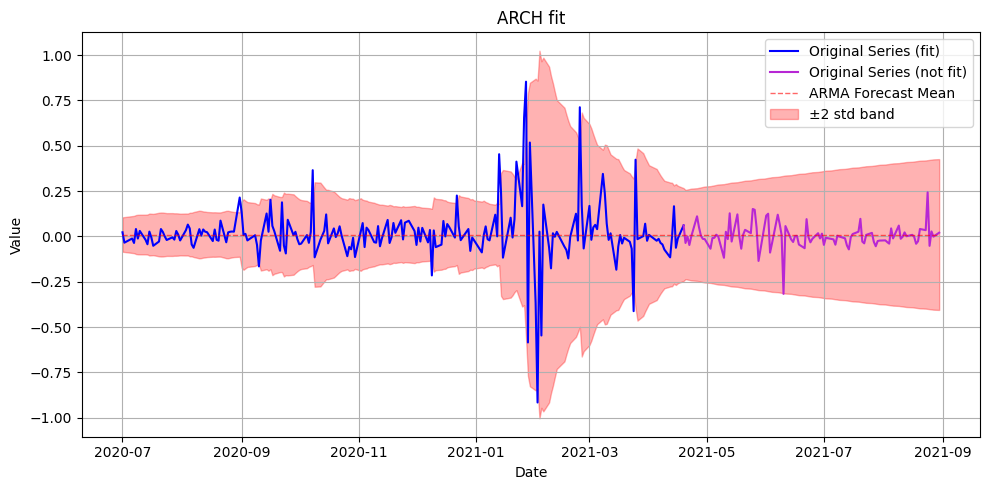

In [13]:
model_pytorch.plot_series(log_returns_GME_nn.loc['2020-07-01':], model_GME, log_returns_GME_nn.loc[:'2021-04-19'].iloc[- window:], scaler = scaler)
model_arch.plot_series(log_returns_GME_nn.loc['2020-07-01':], arch_GME, horizon = 95)

### Apple 2020

Lastly, we will use the NN to model the 2020 behavior of the Apple stock. Similarly to the GME stock above, This model requires smaller training dataset, due to the fact that the 2020 volatility spike for AAPL was considerably milder than that observed for BA, which makes it more important to assign haigher weight to this event during training.

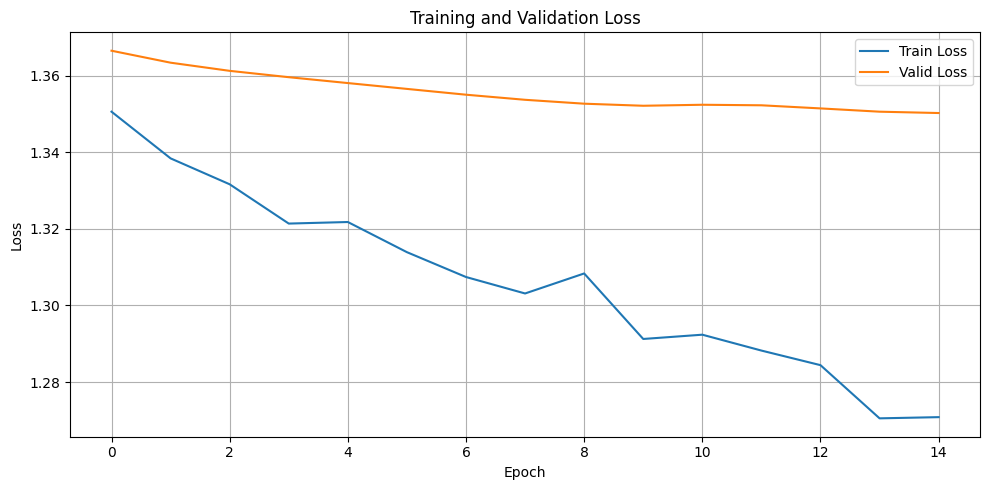

In [14]:
window, horizon = 60, 100

log_returns_AAPL_nn = log_returns_AAPL['2018-01-01':'2020-10-01']
train, valid, scaler = model_pytorch.prepare_dataloaders(log_returns_AAPL_nn.loc[:'2020-05-01'], window, horizon)
model_AAPL, history = model_pytorch.train_model(train, valid, epochs = 15)

model_pytorch.plot_loss_history(history)

Our model manges to correctly predict the volatility ramp-up, but misses some of the more prominent spikes. Nonetheless, it is still capable of producing a solid short-term prediction.

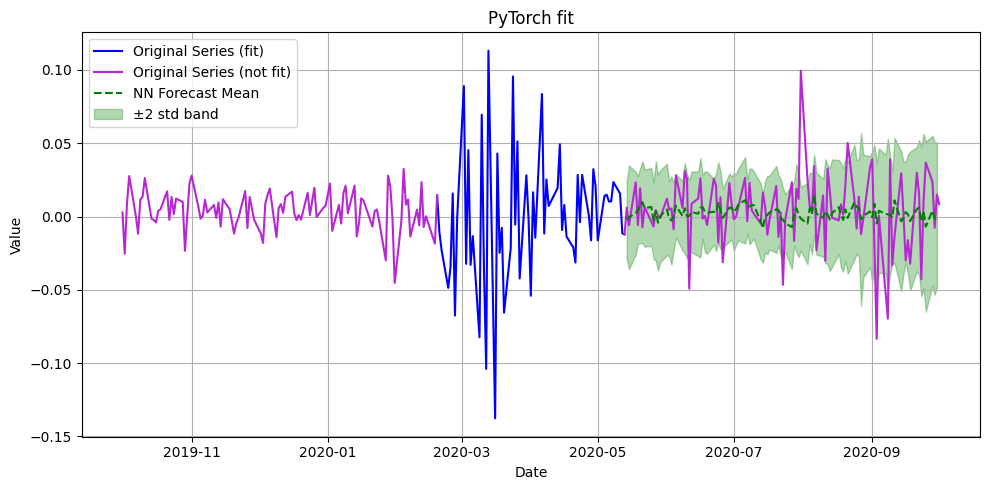

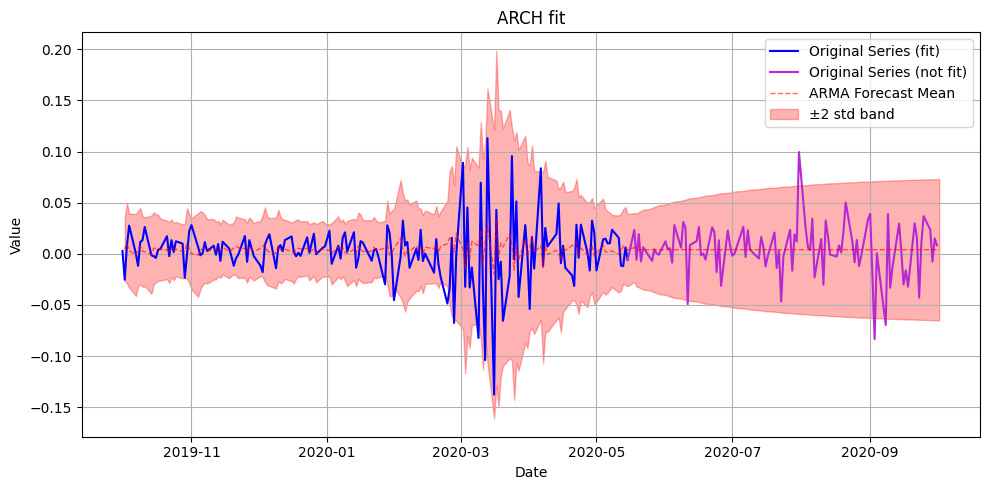

In [15]:
model_pytorch.plot_series(log_returns_AAPL_nn.loc['2019-10-01':], model_AAPL, log_returns_AAPL_nn.loc[:'2020-05-13'].iloc[- window:], scaler = scaler)
model_arch.plot_series(log_returns_AAPL_nn.loc['2019-10-01':], arch_AAPL, horizon = horizon)

## Conclusions

We have developed and tested both an ARCH model and a PyTorch-based neural network capable of forecasting the log returns of various stocks during and after periods of elevated volatility. Both models produced robust predictions of the post-crash volatility decay following the Boeing 2020 crash, as well as volatility ramp-up in Apple stock during the same period. For the Gamestop 2021 short squeeze, the neural network performs impressively in anticipating post-event volatility clustering. However, the exact lengths of the clusters appear to be somewhat parameter-dependent, whereas the ARCH model provides a more conservative prediction in this case.